### TO DO:
- Scales: Consitant Scales and Units: U, I, P, S, Q, _h, Angles
- Delete: Delete unnecessary measurements: total va total_arith vs total_vec
- Ranges: Set min, max values per machine and measurement and filter outliers
- Formulars: Make sure values make sense
    - Current [A] - I1, I2, I3, IN + harmonics: 1.) Rated Current Limits, 2.) I_sys = SUM(I)
    - Current fundamental [A] - I1_f, I2_f, I3_f, IN_f: 1.) Rated Current Limits, 2.) I_f_sys = SUM(I_f), 3.) I >= I_f
    - Current Harmonics [%] - THD, I1_h, I2_h, I3_h, IN_h: 1.) Acceptable limits (5-40%), 2.) THD <~ SUM(I_h)

    - Voltage [U] - U1, U2, U3, U12, U23 + harmonics: 1.) Rated Voltage Limits, 2.) U_avg = SUM(U)
    - Voltage fundamental[U] - U1_f, U2_f, U3_f, U12_f, U23_f: 1.) Rated Voltage Limits, 2.) U_avg_f = SUMU_f, 3.) U >= U_f
    - Voltage Harmonics [%] - THD, U1_h, U2_h, U3_h, U12_h, U23_h: 1.) Acceptable Limits (1-5%), 2.) THD <~ SUM(U_h) 

    - Power [P,S,Q] - P1, P2, P3, S1, S2, S3, Q1, Q2, Q3: 1.) Power limits, 2.) P=Sum(P), S=SUM(S), Q=SUM(Q)
    - Power fundamental [P,S,Q] - P1_f, P2_f, P3_f, S1_f, S2_f, S3_f, Q1_f, Q2_f, Q3_f: 1.) Power limits, 2.) P_tot_f = SUM(P_f) [also S, Q], 3.) P >= P_f [also S, Q]

    - Others: Freq (limits), Angles (limits), 
    - Unknown: LoadType?, Power Factor?, Rotation Field?

In [ ]:
from pathlib import Path
import pandas as pd

def list_paths_and_stats(
    measurement: str,
    root: str | Path = "../dataset_clean",
    validation_root: str | Path = "../dataset_clean_validation",
    *,
    min_ok: float = 49.75,
    max_ok: float = 50.25,
    treat_missing_as_corrupted: bool = True,
):
    """
    Scan measurement files, attach stats (min/max/mean) from the validation CSVs,
    classify each file as validated or corrupted according to min_ok/max_ok limits,
    and print a final summary of ALL, VALIDATED, and CORRUPTED files.

    Parameters
    ----------
    measurement : str
        Measurement name (e.g., "Freq"). Function searches for */<measurement>/*_<measurement>.csv.xz
    root : str | Path
        Root folder containing the cleaned dataset (default: ../dataset_clean)
    validation_root : str | Path
        Root folder containing per-site per-measurement stats CSVs (default: ../dataset_clean_validation)
    min_ok : float
        Lower bound (inclusive) for valid values of the measurement (default: 49.75)
    max_ok : float
        Upper bound (inclusive) for valid values of the measurement (default: 50.25)
    treat_missing_as_corrupted : bool
        If True, files with missing stats (no row match or missing columns) are marked corrupted.

    Returns
    -------
    all_measurement_paths : list[Path]
        Every matched file path.
    validated_measurement : list[dict]
        Each entry: {'path': Path, 'min': float|None, 'max': float|None, 'mean': float|None}
    corrupted_measurement : list[dict]
        Same shape as validated, plus diagnostic flags:
        {'path', 'min', 'max', 'mean', 'reason': {'stats_missing': bool, 'min_below': bool, 'max_above': bool}}
    """
    root = Path(root)
    validation_root = Path(validation_root)

    # --- 1) Discover all measurement files under root ---
    paths = sorted(root.rglob(f"*/{measurement}/*_{measurement}.csv.xz"))
    
    # Containers for results
    validated = []
    corrupted = []

    # --- 2) Iterate files, read matching stats row, classify ---
    for p in paths:
        # Derive stats CSV location and expected row's file_path (strict, Windows-style, relative to dataset_clean).
        site = p.parents[1].name                  # .../<site>/<measurement>/<file>
        year = p.stem.split("_", 1)[0]            # "<year>_<measurement>.csv.xz" -> "<year>"
        stats_path = validation_root / site / measurement / f"{year}_{measurement}_stats.csv"
        expected_rel = f"dataset_clean\\{site}\\{measurement}\\{year}_{measurement}.csv.xz"

        # Defaults if we cannot find stats
        min_v = max_v = mean_v = None
        stats_missing = True

        # Try load stats and extract the exact row by file_path (strict match, backslashes)
        if stats_path.exists():
            df = pd.read_csv(stats_path, dtype={"file_path": "string"})
            if "file_path" in df.columns:
                fp_series = df["file_path"].astype("string").str.replace("/", "\\", regex=False)
                row = df[fp_series == expected_rel]
                if not row.empty:
                    # Pull columns if present; keep None if absent
                    min_v  = row["min"].iloc[0]  if "min"  in row.columns else None
                    max_v  = row["max"].iloc[0]  if "max"  in row.columns else None
                    mean_v = row["mean"].iloc[0] if "mean" in row.columns else None
                    stats_missing = any(
                        k not in row.columns for k in ("min", "max", "mean")
                    )

                    # If present but NaN, treat as missing
                    for val in (min_v, max_v, mean_v):
                        try:
                            # Coerce pandas NA to Python None-like via float() check
                            _ = float(val)
                        except Exception:
                            stats_missing = True
                            break

        # Classification rules:
        # - If stats are missing and treat_missing_as_corrupted=True => corrupted(stats_missing=True)
        # - Else check thresholds on min and max:
        #     min_ok <= min_v AND max_v <= max_ok => validated
        #     otherwise => corrupted with reason flags
        min_below = max_above = False
        reason = {"stats_missing": False, "min_below": False, "max_above": False}

        if stats_missing and treat_missing_as_corrupted:
            reason["stats_missing"] = True
            corrupted.append({
                "path": p,
                "min": min_v,
                "max": max_v,
                "mean": mean_v,
                "reason": reason
            })
        else:
            # Only check limits if we actually have numeric min/max
            try:
                min_val = float(min_v) if min_v is not None else float("nan")
                max_val = float(max_v) if max_v is not None else float("nan")
            except Exception:
                # Non-numeric stats encountered -> treat as missing
                reason["stats_missing"] = True
                corrupted.append({
                    "path": p,
                    "min": min_v,
                    "max": max_v,
                    "mean": mean_v,
                    "reason": reason
                })
                continue

            # Evaluate limit flags (NaN will fail these comparisons and trigger corruption)
            try:
                min_below = not (min_val >= min_ok)
                max_above = not (max_val <= max_ok)
            except Exception:
                min_below = True
                max_above = True

            if (not min_below) and (not max_above):
                validated.append({"path": p, "min": min_v, "max": max_v, "mean": mean_v})
            else:
                reason["min_below"] = min_below
                reason["max_above"] = max_above
                corrupted.append({
                    "path": p,
                    "min": min_v,
                    "max": max_v,
                    "mean": mean_v,
                    "reason": reason
                })

        # Per-file one-line echo (keeps your current preview; NA if None)
        disp_path = str(p).replace("/", "\\")
        fmt = lambda x: "NA" if x is None else f"{float(x):.6g}"
        #print(f"{disp_path}  -  Min {fmt(min_v)}  Max {fmt(max_v)}  Mean {fmt(mean_v)}")

    # --- 3) Print final summary (ALL, VALIDATED, CORRUPTED) ---
    def _format_entry(d):
        disp = str(d["path"]).replace("/", "\\")
        mmin = "NA" if d["min"]  is None else f"{float(d['min']):.6g}"
        mmax = "NA" if d["max"]  is None else f"{float(d['max']):.6g}"
        mavg = "NA" if d["mean"] is None else f"{float(d['mean']):.6g}"
        return f"{disp}  -  Min {mmin}  Max {mmax}  Mean {mavg}"

    #print("\n=== SUMMARY ===")
    #print(f"ALL ({len(paths)}):")
    #for p in paths:
    #    print(str(p).replace("/", "\\"))

    #print(f"\nVALIDATED ({len(validated)}):")
    #for d in validated:
    #    print(_format_entry(d))

    print(f"Found {len(paths)} file(s) for '{measurement}': CORRUPTED ({len(corrupted)})")
 
    for d in corrupted:
       line = _format_entry(d)
       r = d.get("reason", {})
       flags = []
       if r.get("stats_missing"): flags.append("stats_missing")
       if r.get("min_below"):     flags.append(f"min<{min_ok}")
       if r.get("max_above"):     flags.append(f"max>{max_ok}")
       if flags:
           line += "  [" + ", ".join(flags) + "]"
       print(line)

    # --- 4) Return the three lists the caller may want to use programmatically ---
    return paths, validated, corrupted



### Outlier Filter

In [9]:
from __future__ import annotations
from pathlib import Path
import math
from typing import Dict, Tuple, Optional, Iterable
import pandas as pd
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import shutil

def clean_and_backup(
    data_path: str | Path,
    min_ok: float,
    max_ok: float,
    value_col: str | None = None,
    plot_before: bool = True,
    plot_after: bool = True,
):
    """
    ONE-SHOT CLEANER:
    1) (optional) Plot original full series (with time-local red shading where outliers occur).
    2) Print original min/mean/max, original missing, and #outliers to remove.
    3) Build cleaned data + *_stats + *_missing in memory (EXACT schemas).
    4) Move ORIGINAL files (data, stats, missing) into ROOT/backup/<relative path>.
    5) Write CLEANED files into their ORIGINAL locations (overwriting originals).
    6) (optional) Plot cleaned series (same shading), print new min/mean/max, new missing,
       and verify: new_missing == old_missing + outliers_removed.

    Guarantees:
      - Backup tree has ONLY the original files.
      - Original locations end up with ONLY the cleaned files.
    """

    # ---------- Load original data ----------
    p = Path(data_path).resolve()
    assert p.exists(), f"Data file not found: {p}"
    df = pd.read_csv(p, compression="xz")

    # Infer timestamp and measurement (enforce single measurement)
    ts_col = next(c for c in df.columns if pd.to_datetime(df[c], errors="coerce").notna().mean() > 0.99)
    ts = pd.to_datetime(df[ts_col], errors="coerce")
    assert ts.notna().any(), f"Timestamp column '{ts_col}' could not be parsed."

    work = df.drop(columns=[ts_col]).set_index(ts).sort_index()
    numeric_cols = [c for c in work.columns if pd.api.types.is_numeric_dtype(work[c])]
    if value_col is None:
        assert len(numeric_cols) == 1, f"Multiple numeric columns found; set value_col. Found: {numeric_cols}"
        value_col = numeric_cols[0]
    else:
        assert value_col in work.columns and value_col in numeric_cols, f"value_col='{value_col}' invalid."
    s = work[value_col]

    # Outlier + plotting masks
    mask = (s >= min_ok) & (s <= max_ok)
    out_mask = s.notna() & ~mask

    # ---------- Before: plot + stats + outliers ----------
    if plot_before:
        ax = s.plot(figsize=(20, 4), linewidth=0.6, zorder=1)
        yl = ax.get_ylim()
        pad = 0.02 * (yl[1] - yl[0]) if np.isfinite(yl).all() else 0.0
        yl = (yl[0] - pad, yl[1] + pad); ax.set_ylim(*yl)

        # time-local shading only where outliers occur
        ax.fill_between(s.index, yl[0], yl[1], where=out_mask.values, alpha=0.12, color="red", step="pre", zorder=0)

        # guide lines + dots
        ax.axhline(min_ok, linestyle="--", linewidth=0.8, zorder=2)
        ax.axhline(max_ok, linestyle="--", linewidth=0.8, zorder=2)
        ax.scatter(mdates.date2num(s.index[out_mask].to_pydatetime()),s[out_mask].to_numpy(),s=10, marker=".", alpha=0.8, color="red", zorder=3)

        ax.set_title(str(p).replace("/", "\\"))
        ax.set_xlabel("Time"); ax.set_ylabel(value_col); ax.grid(True, linestyle=":", linewidth=0.5)
        plt.tight_layout(); plt.show()

    orig_min, orig_mean, orig_max = s.min(skipna=True), s.mean(skipna=True), s.max(skipna=True)
    orig_missing = int(s.isna().sum())
    outliers = int(((s < min_ok) | (s > max_ok)).sum(skipna=True))
    print(f"ORIGINAL  min={orig_min}, mean={orig_mean}, max={orig_max} | missing={orig_missing} | outliers_to_remove={outliers}")

    # ---------- Clean ----------
    cleaned = s.mask((s < min_ok) | (s > max_ok))
    cleaned_df2 = cleaned.sort_index().reset_index()
    cleaned_df2.columns = [ts_col, value_col]           # EXACT 2 columns, no index
    s_clean = cleaned_df2[value_col]

    # ---------- Resolve project root + destination paths ----------
    # ROOT := parent of the 'dataset_clean' directory containing the data file
    dc_dir = next(par for par in p.parents if par.name == "dataset_clean")
    root = dc_dir.parent

    # Relative path under dataset_clean
    rel_after_dc = p.relative_to(dc_dir).as_posix()  # e.g., EPI_ChipPress/Freq/2023_Freq.csv.xz
    base_name = p.name
    base_no_multi = base_name[:-len(".csv.xz")] if base_name.lower().endswith(".csv.xz") else p.stem

    # Final target paths under ROOT
    data_dst    = p  # cleaned data replaces original
    stats_dst   = (root / "dataset_clean_validation" / Path(rel_after_dc).parent / f"{base_no_multi}_stats.csv").resolve()
    missing_dst = (root / "dataset_clean_validation" / Path(rel_after_dc).parent / f"{base_no_multi}_missing.csv").resolve()

    # Backup targets under ROOT/backup (mirror both trees)
    backup_root = (root / "backup2").resolve()
    data_bak    = (backup_root / "dataset_clean"            / rel_after_dc).resolve()
    stats_bak   = (backup_root / "dataset_clean_validation" / Path(rel_after_dc).parent / f"{base_no_multi}_stats.csv").resolve()
    missing_bak = (backup_root / "dataset_clean_validation" / Path(rel_after_dc).parent / f"{base_no_multi}_missing.csv").resolve()

    # Ensure parents exist for backup & targets
    for q in (data_bak.parent, stats_bak.parent, missing_bak.parent, stats_dst.parent, missing_dst.parent):
        q.mkdir(parents=True, exist_ok=True)

    # ---------- Build CLEAN stats (EXACT schema & order) ----------
    rel_path_str = (Path(dc_dir.name) / rel_after_dc).as_posix().replace("/", "\\")
    file_path_str = rel_path_str
    stats_cols = ["file_path","min","max","mean","std","q01","q05","q25","q50","q75","q95","q99"]
    stats_row = {
        "file_path": file_path_str,
        "min": s_clean.min(skipna=True),
        "max": s_clean.max(skipna=True),
        "mean": s_clean.mean(skipna=True),
        "std": s_clean.std(skipna=True),
        "q01": s_clean.quantile(0.01),
        "q05": s_clean.quantile(0.05),
        "q25": s_clean.quantile(0.25),
        "q50": s_clean.quantile(0.50),
        "q75": s_clean.quantile(0.75),
        "q95": s_clean.quantile(0.95),
        "q99": s_clean.quantile(0.99),
    }
    stats_df = pd.DataFrame([[stats_row[c] for c in stats_cols]], columns=stats_cols)

    # ---------- Build CLEAN missing (EXACT schema & order) ----------
    dt = pd.to_datetime(cleaned_df2[ts_col])
    diffs = np.diff(dt.astype("int64").to_numpy()); med_ns = np.median(diffs) if len(diffs) else 1e9
    step_s = float(med_ns / 1e9) if med_ns > 0 else 1.0

    is_na = s_clean.isna().to_numpy()
    n_total = len(s_clean); n_nans = int(is_na.sum()); n_zeros = int((s_clean == 0).sum(skipna=True))

    # leading/trailing NaNs
    lead = int(np.argmax(~is_na)) if n_total else 0
    if lead == 0 and n_total and is_na[0]: lead = n_total
    rev = is_na[::-1]
    trail = int(np.argmax(~rev)) if n_total else 0
    if trail == 0 and n_total and rev[0]: trail = n_total
    middle = n_nans - lead - trail

    # run-length encode NaN gaps
    gaps, c = [], 0
    for v in is_na:
        if v: c += 1
        elif c: gaps.append(c); c = 0
    if c: gaps.append(c)

    def bucketize(gaps, step):
        bins = {
            "1_step": (0,0), "5s_30s": (5,30), "30s_1m": (30,60), "1m_15m": (60,900),
            "15m_1h": (900,3600), "1h_24h": (3600,86400), "1d_7d": (86400,604800),
            "1w_1mo": (604800,2592000), "1mo_inf": (2592000, np.inf),
        }
        cnt = {k:0 for k in bins}; steps={k:0 for k in bins}
        for L in gaps:
            if L == 1: cnt["1_step"]+=1; steps["1_step"]+=1; continue
            dur = L*step; placed=False
            for k,(lo,hi) in list(bins.items())[1:]:
                if lo <= dur < hi: cnt[k]+=1; steps[k]+=L; placed=True; break
            if not placed: cnt["5s_30s"]+=1; steps["5s_30s"]+=L
        return cnt, steps

    cnt, stp = bucketize(gaps, step_s)
    def pct(steps): return round(100.0 * (steps / n_nans), 2) if n_nans > 0 else 0.0

    miss_cols = [
        "file_path","n_total","n_nans","n_zeros","n_nans_start","n_nans_end","n_nans_middle",
        "n_missing_gaps","missing_gap_total_sec",
        "nan_1_step_count","nan_1_step_steps","nan_1_step_pct",
        "nan_5s_30s_count","nan_5s_30s_steps","nan_5s_30s_pct",
        "nan_30s_1m_count","nan_30s_1m_steps","nan_30s_1m_pct",
        "nan_1m_15m_count","nan_1m_15m_steps","nan_1m_15m_pct",
        "nan_15m_1h_count","nan_15m_1h_steps","nan_15m_1h_pct",
        "nan_1h_24h_count","nan_1h_24h_steps","nan_1h_24h_pct",
        "nan_1d_7d_count","nan_1d_7d_steps","nan_1d_7d_pct",
        "nan_1w_1mo_count","nan_1w_1mo_steps","nan_1w_1mo_pct",
        "nan_1mo_inf_count","nan_1mo_inf_steps","nan_1mo_inf_pct",
    ]
    miss_row = {
        "file_path": file_path_str,
        "n_total": n_total,
        "n_nans": n_nans,
        "n_zeros": n_zeros,
        "n_nans_start": lead,
        "n_nans_end": trail,
        "n_nans_middle": middle,
        "n_missing_gaps": len(gaps),
        "missing_gap_total_sec": int(n_nans * step_s),
        "nan_1_step_count": cnt["1_step"], "nan_1_step_steps": stp["1_step"], "nan_1_step_pct": pct(stp["1_step"]),
        "nan_5s_30s_count": cnt["5s_30s"], "nan_5s_30s_steps": stp["5s_30s"], "nan_5s_30s_pct": pct(stp["5s_30s"]),
        "nan_30s_1m_count": cnt["30s_1m"], "nan_30s_1m_steps": stp["30s_1m"], "nan_30s_1m_pct": pct(stp["30s_1m"]),
        "nan_1m_15m_count": cnt["1m_15m"], "nan_1m_15m_steps": stp["1m_15m"], "nan_1m_15m_pct": pct(stp["1m_15m"]),
        "nan_15m_1h_count": cnt["15m_1h"], "nan_15m_1h_steps": stp["15m_1h"], "nan_15m_1h_pct": pct(stp["15m_1h"]),
        "nan_1h_24h_count": cnt["1h_24h"], "nan_1h_24h_steps": stp["1h_24h"], "nan_1h_24h_pct": pct(stp["1h_24h"]),
        "nan_1d_7d_count": cnt["1d_7d"], "nan_1d_7d_steps": stp["1d_7d"], "nan_1d_7d_pct": pct(stp["1d_7d"]),
        "nan_1w_1mo_count": cnt["1w_1mo"], "nan_1w_1mo_steps": stp["1w_1mo"], "nan_1w_1mo_pct": pct(stp["1w_1mo"]),
        "nan_1mo_inf_count": cnt["1mo_inf"], "nan_1mo_inf_steps": stp["1mo_inf"], "nan_1mo_inf_pct": pct(stp["1mo_inf"]),
    }
    missing_df = pd.DataFrame([[miss_row[c] for c in miss_cols]], columns=miss_cols)

    # ---------- BACKUP originals ONLY ----------
    # originals must exist for all three (we crash if not present)
    assert stats_dst.exists(),   f"Stats file not found: {stats_dst}"
    assert missing_dst.exists(), f"Missing file not found: {missing_dst}"

    # Move originals to backup (no renaming); at this moment, original locations are empty
    for src, dst in ((data_dst, data_bak), (stats_dst, stats_bak), (missing_dst, missing_bak)):
        dst.parent.mkdir(parents=True, exist_ok=True)
        shutil.move(str(src), str(dst))

    # ---------- WRITE CLEAN to original targets ONLY ----------
    # (No clean copies in backup.)
    cleaned_df2.to_csv(data_dst, index=False, compression="xz")  # data
    stats_df.to_csv(stats_dst, index=False)                      # stats
    missing_df.to_csv(missing_dst, index=False)                  # missing

    # ---------- After: plot + stats + consistency check ----------
    if plot_after:
        ax = cleaned_df2.set_index(ts_col)[value_col].plot(figsize=(20, 4), linewidth=0.6, zorder=1)
        yl = ax.get_ylim()
        pad = 0.02 * (yl[1] - yl[0]) if np.isfinite(yl).all() else 0.0
        yl = (yl[0] - pad, yl[1] + pad); ax.set_ylim(*yl)

        # reuse original outlier mask to shade when outliers were present
        ax.fill_between(s.index, yl[0], yl[1], where=out_mask.values, alpha=0.12, color="red", step="pre", zorder=0)
        ax.axhline(min_ok, linestyle="--", linewidth=0.8, zorder=2)
        ax.axhline(max_ok, linestyle="--", linewidth=0.8, zorder=2)
        ax.scatter(mdates.date2num(s.index[out_mask].to_pydatetime()),s[out_mask].to_numpy(),s=10, marker=".", alpha=0.5, color="red", zorder=3)

        ax.set_title("(cleaned) " + str(p).replace("/", "\\"))
        ax.set_xlabel("Time"); ax.set_ylabel(value_col); ax.grid(True, linestyle=":", linewidth=0.5)
        plt.tight_layout(); plt.show()

    new_min, new_mean, new_max = s_clean.min(skipna=True), s_clean.mean(skipna=True), s_clean.max(skipna=True)
    new_missing = int(s_clean.isna().sum())
    print(f"CLEANED   min={new_min}, mean={new_mean}, max={new_max} | missing={new_missing}")
    print(f"CHECK     old_missing({orig_missing}) + outliers({outliers}) == new_missing({new_missing})"
          f" -> {'OK' if (orig_missing + outliers) == new_missing else 'MISMATCH!'}")

# -----------------------------
# Global (non-machine) limits
# -----------------------------
LIMITS_BY_RANGE = {
    (49.0, 51.0): ["Freq", "Freq_f"],
    (-1.0, 1.0): [
        "LoadType1", "LoadType1_f",
        "LoadType2", "LoadType2_f",
        "LoadType3", "LoadType3_f",
    ],
    (-180.0, 180.0): [
        "Angle_U1", "Angle_U1_f",
        "Angle_U2", "Angle_U2_f",
        "Angle_U3", "Angle_U3_f",
        "Angle_UI1", "Angle_UI1_f",
        "Angle_UI2", "Angle_UI2_f",
        "Angle_UI3", "Angle_UI3_f",
    ],
    (2000.0, 25000.0): ["OpHours"],
    (0.0, 100.0): [
        # harmonics (unchanged)
        "U12_h2","U12_h3","U12_h4","U12_h5","U12_h7","U12_h9","U12_h11","U12_h13","U12_h15","U12_h17","U12_h19","U12_h21","U12_h23","U12_h25","U12_h27","U12_h29","U12_h31",
        "U1_h2","U1_h3","U1_h4","U1_h5","U1_h7","U1_h9","U1_h11","U1_h13","U1_h15","U1_h17","U1_h19","U1_h21","U1_h23","U1_h25","U1_h27","U1_h29","U1_h31",
        "U23_h2","U23_h3","U23_h4","U23_h5","U23_h7","U23_h9","U23_h11","U23_h13","U23_h15","U23_h17","U23_h19","U23_h21","U23_h23","U23_h25","U23_h27","U23_h29","U23_h31",
        "U2_h2","U2_h3","U2_h4","U2_h5","U2_h7","U2_h9","U2_h11","U2_h13","U2_h15","U2_h17","U2_h19","U2_h21","U2_h23","U2_h25","U2_h27","U2_h29","U2_h31",
        "U31_h2","U31_h3","U31_h4","U31_h5","U31_h7","U31_h9","U31_h11","U31_h13","U31_h15","U31_h17","U31_h19","U31_h21","U31_h23","U31_h25","U31_h27","U31_h29","U31_h31",
        "U3_h2","U3_h3","U3_h4","U3_h5","U3_h7","U3_h9","U3_h11","U3_h13","U3_h15","U3_h17","U3_h19","U3_h21","U3_h23","U3_h25","U3_h27","U3_h29","U3_h31",
    ],

    (0.0, 100.0): [
    "I1_h2","I1_h3", "I1_h4", "I1_h5", "I1_h7", "I1_h9","I1_h11", "I1_h13", "I1_h15", "I1_h17", "I1_h19", "I1_h21","I1_h23", "I1_h25", "I1_h27", "I1_h29", "I1_h31",
    "I2_h2","I2_h3", "I2_h4", "I2_h5", "I2_h7", "I2_h9","I2_h11", "I2_h13", "I2_h15", "I2_h17", "I2_h19", "I2_h21","I2_h23", "I2_h25", "I2_h27", "I2_h29", "I2_h31",
    "I3_h2","I3_h3", "I3_h4", "I3_h5", "I3_h7", "I3_h9","I3_h11", "I3_h13", "I3_h15", "I3_h17", "I3_h19", "I3_h21","I3_h23", "I3_h25", "I3_h27", "I3_h29", "I3_h31",
    "IN_h2","IN_h3", "IN_h4", "IN_h5", "IN_h7", "IN_h9","IN_h11", "IN_h13", "IN_h15", "IN_h17", "IN_h19", "IN_h21","IN_h23", "IN_h25", "IN_h27", "IN_h29", "IN_h31",
    ]
    
}

# ---------------------------------------------
# Machine specs → used to derive machine limits
# ---------------------------------------------
MACHINE_SPECS: Dict[str, Tuple[str, float, Optional[float]]] = {
    # dir_name: (phase_system, rated_line_voltage_V, rated_current_A)
    # EPI
    "EPI_ChipPress":       ("3P", 400.0, 50.0),
    "EPI_ChipSaw":         ("3P", 400.0, 6.0),
    "EPI_HighTempOven":    ("3P", 400.0, 32.0),
    "EPI_PickAndPlace":    ("1P", 230.0, 5.0),
    "EPI_PumpStation1":    ("3P", 400.0, 34.0),#estimate
    "EPI_PumpStation2":    ("3P", 400.0, 36.0),#estimate
    "EPI_ScreenPrinter":   ("1P", 230.0, 5.2),
    "EPI_SolderOven":      ("3P", 400.0, 29.0),
    "EPI_TotalLoad":       ("3P", 400.0, 160.0),#estimate
    "EPI_VacuumSoldering": ("3P", 400.0, 14.0),# (2x14A,1x7A) → conservative per-phase 14 A
    "EPI_WashingMachine":  ("3P", 400.0, 18.0),#estimate
    # TEC
    "TEC_48S":             ("3P", 400.0, 40.0),#estimate
    "TEC_CFST161":         ("3P", 400.0, 40.0),#estimate
    "TEC_CTX800TC":        ("3P", 400.0, 100.0),
    "TEC_Chiron800":       ("3P", 400.0, 90.0),#estimate
    "TEC_DMF3008":         ("3P", 400.0, 80.0),
    "TEC_DMU125MB":        ("3P", 400.0, 125.0),
    "TEC_DNG50evo":        ("3P", 400.0, 80.0),
    "TEC_E110":            ("3P", 400.0, 80.0),
    "TEC_E30D2":           ("3P", 400.0, 15.0),
    "TEC_JWA24":           ("3P", 400.0, 45.0),#estimate
    "TEC_MV2400R":         ("3P", 400.0, 70.0),
}

def build_machine_limits(
    machine_specs: Dict[str, Tuple[str, float, Optional[float]]] = MACHINE_SPECS,
    *,
    safety_margin: float = 1.15,
    volt_tolerance: float = 0.10,  # ±10% by default
) -> Dict[str, Dict[str, Tuple[float, float]]]:
    """
    Per-machine bounds for:
      U1,U2,U3,U12,U23,U31,
      I1,I2,I3,IN,I_sys,
      S1,S2,S3,S_total_vec,
      P1,P2,P3,P_total,
      Q1,Q2,Q3,Q_total_vec.

    Voltage:
      - 3φ: V_LL = rated_line_voltage, V_LN = V_LL/√3; U_phase ~ V_LN±tol, U_line ~ V_LL±tol.
      - 1φ: V_LN = rated_line_voltage; V_LL = √3·V_LN; apply same channel naming.
    Active power uses symmetric bounds: P ∈ [−S_max, +S_max].
    """
    limits_by_machine: Dict[str, Dict[str, Tuple[float, float]]] = {}

    for machine, (phase_system, rated_line_V, rated_I) in machine_specs.items():
        per: Dict[str, Tuple[float, float]] = {}

        # --- Voltage limits (always defined per machine) ---
        if str(phase_system).upper() == "3P":
            V_LL = float(rated_line_V)
            V_LN = V_LL / math.sqrt(3.0)
        else:  # "1P" → rated_line_V is the single-phase (line-to-neutral) voltage
            V_LN = float(rated_line_V)
            V_LL = V_LN * math.sqrt(3.0)

        U_phase_min = (1.0 - volt_tolerance) * V_LN
        U_phase_max = (1.0 + volt_tolerance) * V_LN
        U_line_min  = (1.0 - volt_tolerance) * V_LL
        U_line_max  = (1.0 + volt_tolerance) * V_LL

        # phase-to-neutral channels
        for m in ("U1", "U2", "U3"):
            per[m] = (U_phase_min, U_phase_max)
        # line-to-line channels
        for m in ("U12", "U23", "U31"):
            per[m] = (U_line_min, U_line_max)

        # If rated current missing, we still return voltage bounds
        if rated_I is None:
            limits_by_machine[machine] = per
            continue

        # --- Currents ---
        I_max_phase = safety_margin * rated_I
        I_max_sys   = safety_margin * math.sqrt(3.0) * rated_I
        for m in ("I1", "I2", "I3"): per[m] = (0.0, I_max_phase)
        per["IN"]    = (0.0, I_max_phase)
        per["I_sys"] = (0.0, I_max_sys)

        # --- Apparent power ---
        if str(phase_system).upper() == "3P":
            S_total_max = safety_margin * (math.sqrt(3.0) * V_LL * rated_I)
            S_phase_max = safety_margin * (V_LN * rated_I)
        else:  # 1φ
            # For 1φ total S = V_LN * I; per-phase S equals total (single energized phase).
            S_total_max = safety_margin * (V_LN * rated_I)
            S_phase_max = S_total_max

        for m in ("S1", "S2", "S3"): per[m] = (0.0, S_phase_max)
        per["S_total_vec"] = (0.0, S_total_max)

        # --- Active power: symmetric using S_max ---
        for m in ("P1", "P2", "P3"): per[m] = (-S_phase_max, S_phase_max)
        per["P_total"] = (-S_total_max, S_total_max)

        # --- Reactive power: bounded by S ---
        for m in ("Q1", "Q2", "Q3"): per[m] = (-S_phase_max, S_phase_max)
        per["Q_total_vec"] = (-S_total_max, S_total_max)

        limits_by_machine[machine] = per

    return limits_by_machine


# --------------------------------------------------------
# Scoped lister: only scans a single machine + measurement
# --------------------------------------------------------
def list_paths_and_stats(
    measurement: str,
    *,
    machine: Optional[str] = None,
    root: str | Path = "../dataset_clean",
    validation_root: str | Path = "../dataset_clean_validation",
    min_ok: float,
    max_ok: float,
    treat_missing_as_corrupted: bool = True,
    quiet: bool = False,
):
    """
    Scan files for ONE measurement, optionally scoped to ONE machine.
    Returns (paths, validated, corrupted). Prints a concise summary unless quiet=True.

    Expected directory layout:
      <root>/<machine>/<measurement>/<year>_<measurement>.csv.xz
      <validation_root>/<machine>/<measurement>/<year>_<measurement>_stats.csv
    """
    root = Path(root)
    validation_root = Path(validation_root)

    if machine is not None:
        search_dir = root / machine / measurement
        paths = sorted(search_dir.glob(f"*_{measurement}.csv.xz"))
    else:
        paths = sorted(root.rglob(f"*/{measurement}/*_{measurement}.csv.xz"))

    validated, corrupted = [], []

    for p in paths:
        site = p.parents[1].name
        year = p.stem.split("_", 1)[0]
        stats_path = validation_root / site / measurement / f"{year}_{measurement}_stats.csv"
        expected_rel = f"dataset_clean\\{site}\\{measurement}\\{year}_{measurement}.csv.xz"

        min_v = max_v = mean_v = None
        stats_missing = True

        if stats_path.exists():
            df = pd.read_csv(stats_path, dtype={"file_path": "string"})
            if "file_path" in df.columns:
                fp_series = df["file_path"].astype("string").str.replace("/", "\\", regex=False)
                row = df[fp_series == expected_rel]
                if not row.empty:
                    min_v  = row["min"].iloc[0]  if "min"  in row.columns else None
                    max_v  = row["max"].iloc[0]  if "max"  in row.columns else None
                    mean_v = row["mean"].iloc[0] if "mean" in row.columns else None
                    stats_missing = any(k not in row.columns for k in ("min","max","mean"))
                    try:
                        _ = float(min_v); _ = float(max_v); _ = float(mean_v)
                    except Exception:
                        stats_missing = True

        reason = {"stats_missing": False, "min_below": False, "max_above": False}

        if stats_missing and treat_missing_as_corrupted:
            reason["stats_missing"] = True
            corrupted.append({"path": p, "min": min_v, "max": max_v, "mean": mean_v, "reason": reason})
            continue

        try:
            min_val = float(min_v) if min_v is not None else float("nan")
            max_val = float(max_v) if max_v is not None else float("nan")
        except Exception:
            reason["stats_missing"] = True
            corrupted.append({"path": p, "min": min_v, "max": max_v, "mean": mean_v, "reason": reason})
            continue

        min_below = not (min_val >= min_ok)
        max_above = not (max_val <= max_ok)

        if (not min_below) and (not max_above):
            validated.append({"path": p, "min": min_v, "max": max_v, "mean": mean_v})
        else:
            reason["min_below"] = min_below
            reason["max_above"] = max_above
            corrupted.append({"path": p, "min": min_v, "max": max_v, "mean": mean_v, "reason": reason})

    if not quiet:
        disp_machine = machine or "<ALL>"
        print(f"Found {len(paths)} file(s) for '{measurement}' [{min_ok:.2f}:{max_ok:.2f}] on {disp_machine}: CORRUPTED ({len(corrupted)})")
        

    return paths, validated, corrupted

import pandas as pd
import numpy as np  # NEW

# --- NEW: robust value-column picker -----------------------------------------
def _pick_value_column(header: Iterable[str], preferred: Optional[str]) -> str:
    cols = list(header)
    if preferred in cols:
        return preferred
    # heuristics: nimm die erste *numerische* Datenspalte, ignoriere offensichtliche Zeit/Index-Spalten
    blacklist = {"time", "timestamp", "date", "datetime", "idx", "index"}
    for c in cols:
        lc = str(c).strip().lower()
        if lc in blacklist:
            continue
        # prefer names that look like measurements (letters+digits+_); fallback to the first non-blacklisted
        return c
    # fallback: erste Spalte
    return cols[0] if cols else preferred or "value"

# --- NEW: zähle Ausreißer ohne alles in den RAM zu laden ----------------------
def count_outliers_in_file(
    file_path: str | Path,
    measurement: str,
    *,
    min_ok: float,
    max_ok: float,
    assume_header: bool = True,
    chunksize: int = 200_000,
) -> Tuple[int, int, int]:
    """
    Returns (n_total, n_outliers, n_nans) for the measurement column in file_path.
    - Versucht zuerst die Spalte `measurement` zu lesen (usecols).
    - Wenn nicht vorhanden, liest nur Header und wählt heuristisch eine Value-Spalte.
    - Streamt in Chunks (RAM-freundlich), zählt <min_ok bzw. >max_ok sowie NaNs.
    """
    fp = str(file_path)
    # 1) Versuche direkt die gewünschte Spalte
    try:
        reader = pd.read_csv(
            fp,
            usecols=[measurement],
            compression="infer",
            chunksize=chunksize,
            dtype={measurement: "float32"},
            low_memory=True,
        )
        col = measurement
    except ValueError:
        # 2) Spalte nicht gefunden → Header lesen und heuristisch wählen
        header = pd.read_csv(fp, nrows=0, compression="infer").columns
        col = _pick_value_column(header, measurement)
        reader = pd.read_csv(
            fp,
            usecols=[col],
            compression="infer",
            chunksize=chunksize,
            dtype={col: "float32"},
            low_memory=True,
        )

    n_total = 0
    n_out = 0
    n_nan = 0

    for chunk in reader:
        s = chunk[col]
        # NaNs
        nan_mask = s.isna()
        n_nan += int(nan_mask.sum())
        # gültige Werte
        s_valid = s[~nan_mask]
        n_total += int(s.shape[0])
        if not s_valid.empty:
            out_mask = (s_valid < min_ok) | (s_valid > max_ok)
            n_out += int(out_mask.sum())

    return n_total, n_out, n_nan

# ---------------------------------------------------------
# Orchestrator: per-machine, per-measurement outlier clean
# ---------------------------------------------------------
def process_measurements(
    *,
    meas_list: Iterable[str],
    clean_and_backup,                      # your cleaner (unchanged)
    machine_limits: Optional[Dict[str, Dict[str, Tuple[float, float]]]] = None,
    global_limits_by_range: Dict[Tuple[float, float], Iterable[str]] = LIMITS_BY_RANGE,
    machines_to_analyze: Optional[Iterable[str]] = None,
    exclude_if_name_contains: Iterable[str] = ("PV",),
    root: str | Path = "../dataset_clean",
    validation_root: str | Path = "../dataset_clean_validation",
    script_dir: Optional[Path] = None,
    treat_missing_as_corrupted: bool = True,
    testmode: bool = True,
):
    """
    Runs outlier detection (and optional cleaning) with machine-scoped limits.
    Voltage limits are also per machine (derived from phase system & rated voltage).
    """
    if script_dir is None:
        script_dir = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()

    def _is_excluded(name: str) -> bool:
        low = name.lower()
        return any(tag.lower() in low for tag in (exclude_if_name_contains or ()))

    # Build machine list
    if machines_to_analyze is None:
        if machine_limits:
            machines_to_analyze = [m for m in machine_limits.keys() if not _is_excluded(m)]
        else:
            machines_to_analyze = [d.name for d in Path(root).iterdir() if d.is_dir() and not _is_excluded(d.name)]
    machines_to_analyze = list(machines_to_analyze or [])

    # Reverse global limits for quick lookup (used only if machine lacks a bound)
    global_by_meas: Dict[str, Tuple[float, float]] = {}
    for (lo, hi), names in global_limits_by_range.items():
        for n in names:
            global_by_meas[n] = (lo, hi)

    for meas in meas_list:
        print(f"\n=== Processing measurement '{meas}' ===")
        for machine in machines_to_analyze:
            # Prefer machine-wise limits; otherwise fallback to global (harmonics, etc.)
            lo_hi = None
            if machine_limits and meas in machine_limits.get(machine, {}):
                lo_hi = machine_limits[machine][meas]
            elif meas in global_by_meas:
                lo_hi = global_by_meas[meas]

            if lo_hi is None:
                print(f"[SKIP] No limits for '{meas}' on {machine} (neither machine-wise nor global).")
                continue

            min_ok, max_ok = lo_hi

            # List+classify for this machine only
            paths, validated, corrupted = list_paths_and_stats(
                meas,
                machine=machine,
                root=root,
                validation_root=validation_root,
                min_ok=min_ok,
                max_ok=max_ok,
                treat_missing_as_corrupted=treat_missing_as_corrupted,
                quiet=False,
            )

            # --- innerhalb von process_measurements(), im Cleaning-Loop ---
            bad_files = []
            total = len(corrupted)
            for i, entry in enumerate(corrupted, start=1):
                path_str = str(entry["path"]).replace("/", "\\")
                try:
                    # NEW: Ausreißer zählen (streaming)
                    try:
                        n_total, n_out, n_nan = count_outliers_in_file(
                            path_str, meas, min_ok=min_ok, max_ok=max_ok
                        )
                        pct = (n_out / n_total) if n_total > 0 else 0.0
                        outlier_info = f" | outliers: {n_out}/{n_total} ({pct:.2%}), NaN: {n_nan}"
                    except Exception as _e:
                        # Falls Datei-/Spaltenlayout unerwartet ist, weiter machen, aber kenntlich machen
                        outlier_info = " | outliers: n/a (count failed)"

                    if testmode:
                        print(
                            f"[{i}/{total}] {path_str} -> TESTMODE: Would clean+backup "
                            f"with limits ({min_ok:.2f}, {max_ok:.2f}){outlier_info}"
                        )
                    else:
                        clean_and_backup(
                            path_str,
                            min_ok=min_ok,
                            max_ok=max_ok,
                            plot_before=False,
                            plot_after=False,
                        )
                        # Optional nach echtem Clean: erneut zählen/loggen – hier sparen wir uns das aus Performancegründen.
                except EOFError:
                    print(f"  -> Skipped (EOF/compression): {path_str}")
                    bad_files.append(path_str)
                except Exception as e:
                    print(f"  -> Skipped ({type(e).__name__}): {path_str}")
                    bad_files.append(path_str)


# -----------------
# Example usage
# -----------------
# 1) Build machine-wise limits (now includes voltage, currents, powers)
MACHINE_LIMITS = build_machine_limits(MACHINE_SPECS, safety_margin=1.2, volt_tolerance=0.10)

# 2) Choose arrays
measurements_voltages = ["U1","U2","U3","U12","U23","U31"]
measurements_currents = ["I1","I2","I3","IN","I_sys"]
measurements_powers   = ["P1","P2","P3","P_total","S1","S2","S3","S_total_vec","Q1","Q2","Q3","Q_total_vec"]


# 3) Run
process_measurements(
    meas_list=measurements_voltages + measurements_currents + measurements_powers,
    clean_and_backup=clean_and_backup,
    machine_limits=MACHINE_LIMITS,
    machines_to_analyze=list(MACHINE_SPECS.keys()),
    root="../dataset_clean",
    validation_root="../dataset_clean_validation",
    testmode=False,
)



=== Processing measurement 'U1' ===
Found 7 file(s) for 'U1' [207.85:254.03] on EPI_ChipPress: CORRUPTED (0)
Found 7 file(s) for 'U1' [207.85:254.03] on EPI_ChipSaw: CORRUPTED (0)
Found 7 file(s) for 'U1' [207.85:254.03] on EPI_HighTempOven: CORRUPTED (0)
Found 7 file(s) for 'U1' [207.00:253.00] on EPI_PickAndPlace: CORRUPTED (0)
Found 7 file(s) for 'U1' [207.85:254.03] on EPI_PumpStation1: CORRUPTED (0)
Found 7 file(s) for 'U1' [207.85:254.03] on EPI_PumpStation2: CORRUPTED (0)
Found 7 file(s) for 'U1' [207.00:253.00] on EPI_ScreenPrinter: CORRUPTED (0)
Found 7 file(s) for 'U1' [207.85:254.03] on EPI_SolderOven: CORRUPTED (0)
Found 7 file(s) for 'U1' [207.85:254.03] on EPI_TotalLoad: CORRUPTED (0)
Found 7 file(s) for 'U1' [207.85:254.03] on EPI_VacuumSoldering: CORRUPTED (0)
Found 7 file(s) for 'U1' [207.85:254.03] on EPI_WashingMachine: CORRUPTED (0)
Found 1 file(s) for 'U1' [207.85:254.03] on TEC_48S: CORRUPTED (0)
Found 1 file(s) for 'U1' [207.85:254.03] on TEC_CFST161: CORRUPTED 

In [ ]:
# I1_f, I2_f, I3_f, IN_f, I_sys_f
#P1_f, P2_f, P3_f, 
# PF1_h, PF2_h, PF3_h, PF_total_f, PF_total_arith_f

Mean 1058.03718409878 Min 0.0 - Max 11319.171


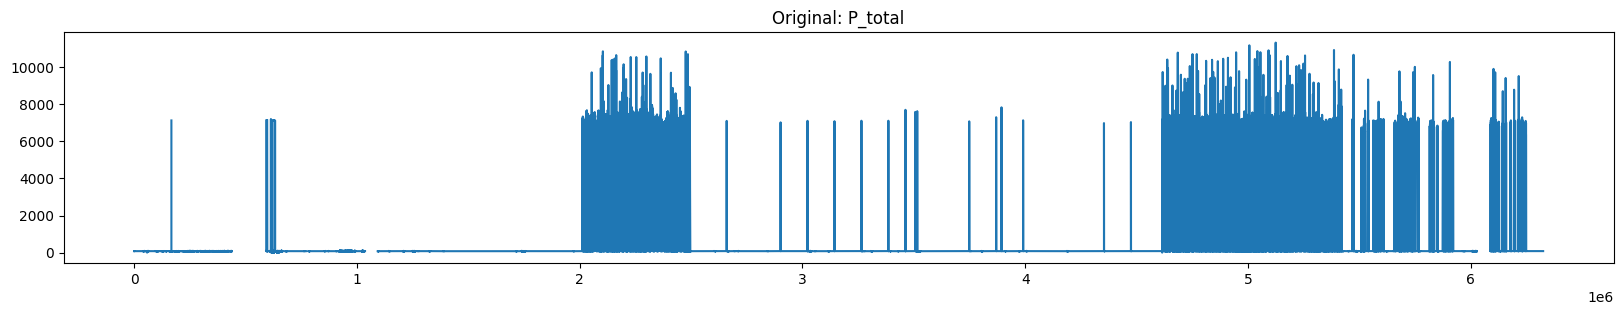

In [8]:
df = pd.read_csv(r"..\dataset_clean\TEC_CFST161\P_total\2024_P_total.csv.xz")
col = df.select_dtypes("number").columns[0]  # first numeric series
print(f"Mean {df[col].mean()} Min {df[col].min()} - Max {df[col].max()}")
plt.figure(figsize=(20, 3))
df[col].plot(title=f"Original: {col}")
plt.show()

### Old

In [ ]:
# I1, I2, I3, IN, I1_f, I2_f, I3_f, IN_f, I_sys, I_sys_f
# P1, P2, P3, P_total, P1_f, P2_f, P3_f
# PF1, PF1_h, PF2, PF2_h, PF3, PF3_h, PF_total

In [ ]:
measurements_others = ["Freq", "Freq_f","LoadType1", "LoadType1_f","LoadType2", "LoadType2_f","LoadType3", "LoadType3_f","Angle_U1", "Angle_U1_f",
    "Angle_U2", "Angle_U2_f","Angle_U3", "Angle_U3_f","Angle_UI1","Angle_UI1_f","Angle_UI2", "Angle_UI2_f","Angle_UI3", "Angle_UI3_f","OpHours",]

measurements_u_hramonics = [
    "U12_h2", "U12_h3", "U12_h4", "U12_h5", "U12_h7", "U12_h9","U12_h11", "U12_h13", "U12_h15", "U12_h17", "U12_h19", "U12_h21","U12_h23", "U12_h25", "U12_h27", "U12_h29", "U12_h31",
    "U1_h2","U1_h3", "U1_h4", "U1_h5", "U1_h7", "U1_h9","U1_h11", "U1_h13", "U1_h15", "U1_h17", "U1_h19", "U1_h21","U1_h23", "U1_h25", "U1_h27", "U1_h29", "U1_h31",
    "U23_h2", "U23_h3", "U23_h4", "U23_h5", "U23_h7", "U23_h9","U23_h11", "U23_h13", "U23_h15", "U23_h17", "U23_h19", "U23_h21","U23_h23", "U23_h25", "U23_h27", "U23_h29", "U23_h31",
    "U2_h2", "U2_h3", "U2_h4", "U2_h5", "U2_h7", "U2_h9","U2_h11", "U2_h13", "U2_h15", "U2_h17", "U2_h19", "U2_h21","U2_h23", "U2_h25", "U2_h27", "U2_h29", "U2_h31",
    "U31_h2", "U31_h3", "U31_h4", "U31_h5", "U31_h7", "U31_h9","U31_h11", "U31_h13", "U31_h15", "U31_h17", "U31_h19", "U31_h21","U31_h23", "U31_h25", "U31_h27", "U31_h29", "U31_h31",
    "U3_h2", "U3_h3", "U3_h4", "U3_h5", "U3_h7", "U3_h9","U3_h11", "U3_h13", "U3_h15", "U3_h17", "U3_h19", "U3_h21","U3_h23", "U3_h25", "U3_h27", "U3_h29", "U3_h31",]

measurements_i_harmonics = [
    "I1_h2","I1_h3", "I1_h4", "I1_h5", "I1_h7", "I1_h9","I1_h11", "I1_h13", "I1_h15", "I1_h17", "I1_h19", "I1_h21","I1_h23", "I1_h25", "I1_h27", "I1_h29", "I1_h31",
    "I2_h2","I2_h3", "I2_h4", "I2_h5", "I2_h7", "I2_h9","I2_h11", "I2_h13", "I2_h15", "I2_h17", "I2_h19", "I2_h21","I2_h23", "I2_h25", "I2_h27", "I2_h29", "I2_h31",
    "I3_h2","I3_h3", "I3_h4", "I3_h5", "I3_h7", "I3_h9","I3_h11", "I3_h13", "I3_h15", "I3_h17", "I3_h19", "I3_h21","I3_h23", "I3_h25", "I3_h27", "I3_h29", "I3_h31",
    "IN_h2","IN_h3", "IN_h4", "IN_h5", "IN_h7", "IN_h9","IN_h11", "IN_h13", "IN_h15", "IN_h17", "IN_h19", "IN_h21","IN_h23", "IN_h25", "IN_h27", "IN_h29", "IN_h31",
]



In [22]:
paths, validated, corrupted = list_paths_and_stats("I1", min_ok=-100000, max_ok=100000)


Found 81 file(s) for 'I1': CORRUPTED (0)


PF1: Mean 638.2896805242718 Min 0.0 - Max 17663.043


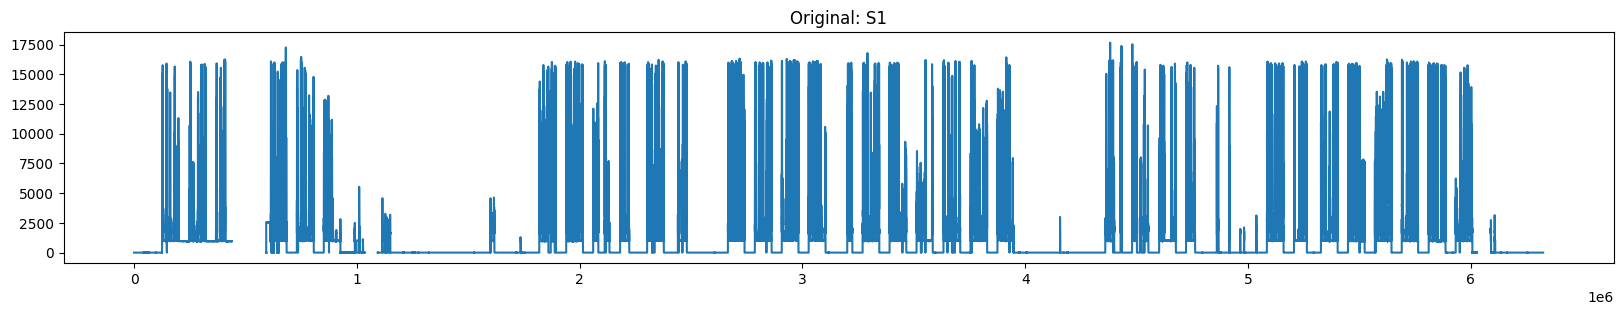

In [14]:
df = pd.read_csv(r"..\dataset_clean\TEC_MV2400R\S1\2024_S1.csv.xz")
col = df.select_dtypes("number").columns[0]  # first numeric series
print(f"PF1: Mean {df[col].mean()} Min {df[col].min()} - Max {df[col].max()}")
plt.figure(figsize=(20, 3))
df[col].plot(title=f"Original: {col}")
plt.show()

In [15]:
# 0.) Set Hardcoded measurement limits: {(min, max): [measurement names]}
LIMITS_BY_RANGE = {
    (49.0, 51.0): [
        "Freq", "Freq_f",
    ],

    (-1.0, 1.0): [
        "LoadType1", "LoadType1_f",
        "LoadType2", "LoadType2_f",
        "LoadType3", "LoadType3_f",
    ],

    (-180.0, 180.0): [
        "Angle_U1", "Angle_U1_f",
        "Angle_U2", "Angle_U2_f",
        "Angle_U3", "Angle_U3_f",
        "Angle_UI1", "Angle_UI1_f",
        "Angle_UI2", "Angle_UI2_f",
        "Angle_UI3", "Angle_UI3_f",
    ],

    (2000.0, 25000.0): [
        "OpHours",
    ],

    (0.0, 100.0): [
        # U12 harmonics
        "U12_h2", "U12_h3", "U12_h4", "U12_h5", "U12_h7", "U12_h9",
        "U12_h11", "U12_h13", "U12_h15", "U12_h17", "U12_h19", "U12_h21",
        "U12_h23", "U12_h25", "U12_h27", "U12_h29", "U12_h31",

        # U1 harmonics
        "U1_h2", "U1_h3", "U1_h4", "U1_h5", "U1_h7", "U1_h9",
        "U1_h11", "U1_h13", "U1_h15", "U1_h17", "U1_h19", "U1_h21",
        "U1_h23", "U1_h25", "U1_h27", "U1_h29", "U1_h31",

        # U23 harmonics
        "U23_h2", "U23_h3", "U23_h4", "U23_h5", "U23_h7", "U23_h9",
        "U23_h11", "U23_h13", "U23_h15", "U23_h17", "U23_h19", "U23_h21",
        "U23_h23", "U23_h25", "U23_h27", "U23_h29", "U23_h31",

        # U2 harmonics
        "U2_h2", "U2_h3", "U2_h4", "U2_h5", "U2_h7", "U2_h9",
        "U2_h11", "U2_h13", "U2_h15", "U2_h17", "U2_h19", "U2_h21",
        "U2_h23", "U2_h25", "U2_h27", "U2_h29", "U2_h31",

        # U31 harmonics
        "U31_h2", "U31_h3", "U31_h4", "U31_h5", "U31_h7", "U31_h9",
        "U31_h11", "U31_h13", "U31_h15", "U31_h17", "U31_h19", "U31_h21",
        "U31_h23", "U31_h25", "U31_h27", "U31_h29", "U31_h31",

        # U3 harmonics
        "U3_h2", "U3_h3", "U3_h4", "U3_h5", "U3_h7", "U3_h9",
        "U3_h11", "U3_h13", "U3_h15", "U3_h17", "U3_h19", "U3_h21",
        "U3_h23", "U3_h25", "U3_h27", "U3_h29", "U3_h31",
    ],
    (207,253): ["U1", "U2", "U3",],
    (360,440): ["U12", "U23", "U31",],
}


In [21]:
from pathlib import Path
measurements5 = ["U1", "U2", "U3"]
measurements6 = ["U12", "U23", "U31"]

def process_measurement(
    meas_list,
    LIMITS_BY_RANGE,
    list_paths_and_stats,
    clean_and_backup,
    script_dir=None,
    testmode=True,
):
    """
    Process measurements in meas_list using limit bounds from LIMITS_BY_RANGE.
    - If testmode is True, do not modify or back up any files; only simulate and log actions.
    """

    if script_dir is None:
        script_dir = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()

    for meas in meas_list:
        # --- find min/max for this measurement from LIMITS_BY_RANGE ---
        min_ok = max_ok = None
        for (lo, hi), names in LIMITS_BY_RANGE.items():
            if meas in names:
                min_ok, max_ok = lo, hi
                break

        if min_ok is None or max_ok is None:
            print(f"[SKIP] No limits found for '{meas}' in LIMITS_BY_RANGE.")
            continue

        print(f"\n=== Processing '{meas}' with limits [{min_ok}:{max_ok}] ===")

        # --- 1) list all + validated/corrupted with correct limits for this measurement ---
        paths, validated, corrupted = list_paths_and_stats(meas, min_ok=min_ok, max_ok=max_ok)

        # --- 2) try to fix all corrupted files for this measurement ---
        subset = corrupted
        total = len(subset)
        bad_files = []

        if total == 0:
            print(f"No corrupted files detected for '{meas}'.")
            continue

        for i, entry in enumerate(subset, start=1):
            path_str = str(entry["path"]).replace("/", "\\")
            print(f"[{i}/{total}] {path_str}")
            try:
                if testmode:
                    print(f"  -> TESTMODE: Would clean and backup: {path_str} (limits: {min_ok}, {max_ok})")
                else:
                    clean_and_backup(
                        path_str,
                        min_ok=min_ok,
                        max_ok=max_ok,
                        plot_before=False,
                        plot_after=False,
                    )
            except EOFError:
                print(f"  -> Skipped (corrupted/compressed EOF): {path_str}")
                bad_files.append(path_str)
            except Exception as e:
                print(f"  -> Skipped ({type(e).__name__}): {path_str}")
                bad_files.append(path_str)

        # --- 3) write out any files we couldn't read for this measurement ---
        if bad_files:
            out = script_dir / f"corrupted_files_{meas}.txt"
            msg = f"\nSkipped {len(bad_files)} files due to read errors. List saved to: {out}"
            if not testmode:
                out.write_text("\n".join(bad_files), encoding="utf-8")
                print(msg)
            else:
                print(f"\nTESTMODE: {len(bad_files)} files would be listed as unreadable at {out}")
        else:
            print("\nAll files processed without read errors.")

# Example usage:
process_measurement(
    meas_list=measurements6,
    LIMITS_BY_RANGE=LIMITS_BY_RANGE,
    list_paths_and_stats=list_paths_and_stats,
    clean_and_backup=clean_and_backup,
    script_dir=None,   # or provide your path
    testmode=False      # True for dry-run, False for actual processing
)



=== Processing 'U12' with limits [360:440] ===
Found 74 file(s) for 'U12': CORRUPTED (42)
[1/42] ..\dataset_clean\EPI_ChipPress\U12\2022_U12.csv.xz
ORIGINAL  min=0.0, mean=407.6726188367994, max=420.06 | missing=1296147 | outliers_to_remove=3224
CLEANED   min=394.95, mean=407.9350751872718, max=420.06 | missing=1299371
CHECK     old_missing(1296147) + outliers(3224) == new_missing(1299371) -> OK
[2/42] ..\dataset_clean\EPI_ChipPress\U12\2023_U12.csv.xz
ORIGINAL  min=0.0, mean=409.0490245381435, max=655.39 | missing=1786972 | outliers_to_remove=258
CLEANED   min=396.73, mean=409.0541033524566, max=418.99 | missing=1787230
CHECK     old_missing(1786972) + outliers(258) == new_missing(1787230) -> OK
[3/42] ..\dataset_clean\EPI_ChipPress\U12\2024_U12.csv.xz
ORIGINAL  min=0.0, mean=409.0706927910369, max=418.74 | missing=1554196 | outliers_to_remove=113
CLEANED   min=396.03, mean=409.08038321686973, max=418.74 | missing=1554309
CHECK     old_missing(1554196) + outliers(113) == new_missing(

In [9]:
# Assume LIMITS_BY_RANGE is already defined like:
# LIMITS_BY_RANGE = { (min_val, max_val): [ "MeasA", "MeasB", ... ], ... }

script_dir = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()

for meas in ["U1"]:
    # --- find min/max for this measurement from LIMITS_BY_RANGE (no helper function) ---
    min_ok = max_ok = None
    for (lo, hi), names in LIMITS_BY_RANGE.items():
        if meas in names:
            min_ok, max_ok = lo, hi
            break

    if min_ok is None or max_ok is None:
        print(f"[SKIP] No limits found for '{meas}' in LIMITS_BY_RANGE.")
        continue

    print(f"\n=== Processing '{meas}' with limits [{min_ok}:{max_ok}] ===")

    
    # --- 1) list all + validated/corrupted with correct limits for this measurement ---
    paths, validated, corrupted = list_paths_and_stats(meas, min_ok=min_ok, max_ok=max_ok)

    
    
    # --- 2) try to fix all corrupted files for this measurement ---
    subset = corrupted  # process ALL corrupted files for this measurement
    total = len(subset)
    bad_files = []

    if total == 0:
        print(f"No corrupted files detected for '{meas}'.")
        continue

    for i, entry in enumerate(subset, start=1):
        path_str = str(entry["path"]).replace("/", "\\")
        print(f"[{i}/{total}] {path_str}")
        try:
            clean_and_backup(
                path_str,
                min_ok=min_ok,   # use the measurement-specific limits
                max_ok=max_ok,
                plot_before=False,
                plot_after=False,
            )
        except EOFError:
            print(f"  -> Skipped (corrupted/compressed EOF): {path_str}")
            bad_files.append(path_str)
        except Exception as e:
            print(f"  -> Skipped ({type(e).__name__}): {path_str}")
            bad_files.append(path_str)

    # --- 3) write out any files we couldn't read for this measurement ---
    if bad_files:
        out = script_dir / f"corrupted_files_{meas}.txt"
        out.write_text("\n".join(bad_files), encoding="utf-8")
        print(f"\nSkipped {len(bad_files)} files due to read errors. List saved to: {out}")
    else:
        print("\nAll files processed without read errors.")



=== Processing 'LoadType1' with limits [-1.0:1.0] ===
Found 11 file(s) for 'LoadType1':

CORRUPTED (1):
[1/1] ..\dataset_clean\TEC_48S\LoadType1\2024_LoadType1.csv.xz
ORIGINAL  min=0.0, mean=0.9999954285400814, max=1.0 | missing=5886983 | outliers_to_remove=0
  -> Skipped (AssertionError): ..\dataset_clean\TEC_48S\LoadType1\2024_LoadType1.csv.xz

Skipped 1 files due to read errors. List saved to: d:\EnergyDataset\scripts\corrupted_files_LoadType1.txt


In [ ]:
"Chip Press": EPI_ChipPress
"Chip Saw": EPI_ChipSaw
"High Temperature Oven": EPI_HighTempOven
"Pick and Place Machine": EPI_PickAndPlace
"Pump Station 1": EPI_PumpStation1
"Pump Station 2": EPI_PumpStation2
"ScreenPrinter": EPI_ScreenPrinter
"Solder Oven": EPI_SolderOven
"Main Terminal": EPI_TotalLoad
"Vacuum Soldering System": EPI_VacuumSoldering
"Washing Machine": EPI_WashingMachine
"Lathe machine 2": TEC_48S
"Water chiller": TEC_CFST161
"Lathe milling machine": TEC_CTX800TC
"5-axis milling machine 1": TEC_Chiron800
"5-axis milling machine 2": TEC_DMF3008
"5-axis milling machine 3": TEC_DMU125MB
"Milling machine": TEC_DNG50evo
"Lathe machine": TEC_E110
"Lathe machine 1": TEC_E30D2
"Liquid cooler": TEC_JWA24
"Wire EDM machine": TEC_MV2400R